# Classificador KNN para a Adult Base

In [6]:
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns

In [7]:
train = pd.read_csv("~/Downloads/adult-pmr3508/train_data.csv", 
                     sep = r'\s*,\s*', engine  = 'python',  na_values = "?")

train

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,48835,42,Private,384236,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,7688,0,40,United-States,>50K
32556,48836,23,Private,129042,HS-grad,9,Never-married,Machine-op-inspct,Unmarried,Black,Female,0,0,40,United-States,<=50K
32557,48837,30,Private,195488,HS-grad,9,Never-married,Priv-house-serv,Own-child,White,Female,0,0,40,Guatemala,<=50K
32558,48838,18,Private,27620,HS-grad,9,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,25,United-States,<=50K


## 1. Organização da base de dados

Por meio da análise dos gráficos conseguiremos determinar inicialmente as relações entre as outras features e o income. 

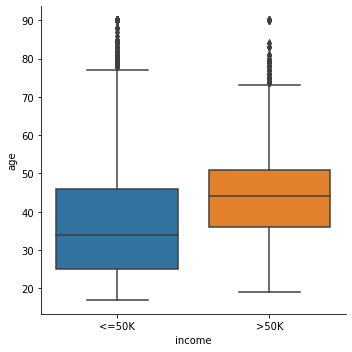

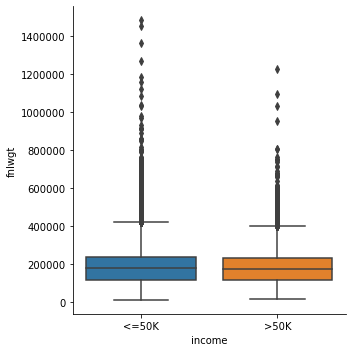

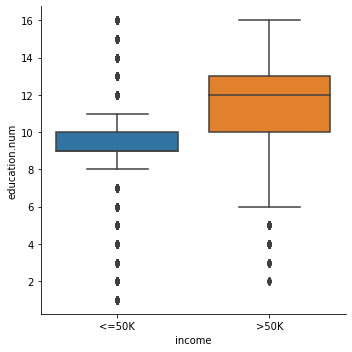

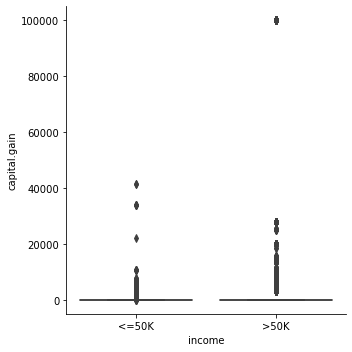

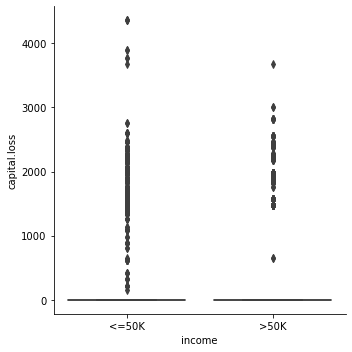

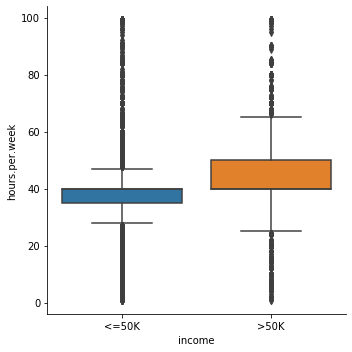

In [8]:
#analise dos dados numericos
colums = [ "age", "fnlwgt", "education.num", "capital.gain", "capital.loss","hours.per.week"]
analise = train.copy()
for i in colums:
    sns.catplot(x = "income", y = i, kind = "box", data = analise)

Nessa primeira análise, podemos ver que o parâmetro fnlwgt tem praticamente o mesmo comportamento independente do income apresentado e por tanto pode ser desconsiderado. É possível observar também que os parâmetros capital gain e capital loss são muito dispersos e portanto criar um outro parâmetro que una os dois e diminua o efeito dos outliers se mostra necessário.

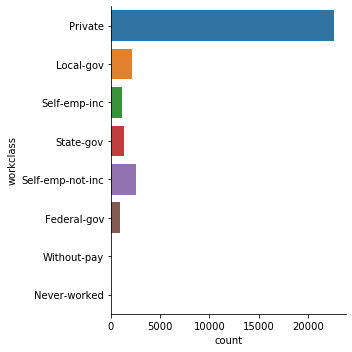

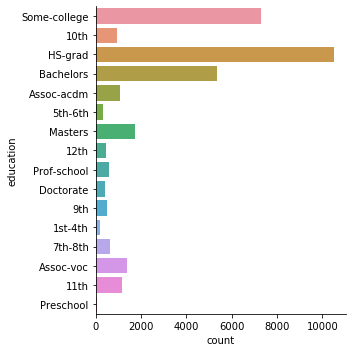

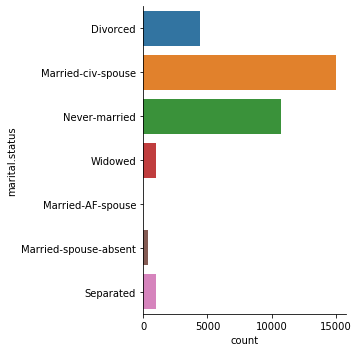

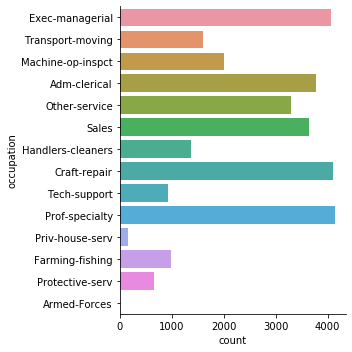

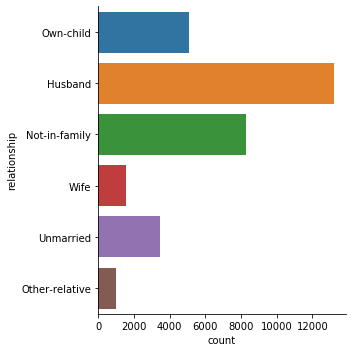

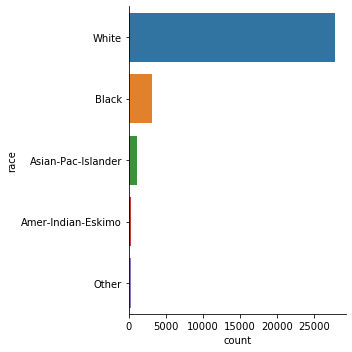

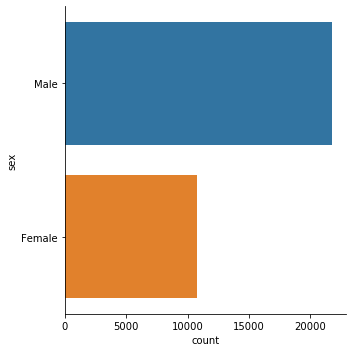

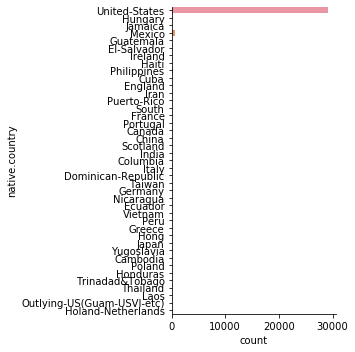

In [9]:
#analise dos dados qualitativos
qualitativos = [ "workclass", "education",  "marital.status",
            "occupation", "relationship", "race", "sex", "native.country"]

for i in qualitativos:
    sns.catplot(y = i,  kind = "count", data = analise)

Já nesse caso, vemos que a presença da nacionalidade americana é muito maior do que a de qualquer outro país e por tanto o uso dessa medida de análise não beneficiará o modelo.

In [10]:
#diminui o efeito dos outliers 
train["capital"] = train['capital.gain'] - train['capital.loss']

cap = ["capital"]
train[cap] = RobustScaler().fit_transform(train[cap])

#variaveis descartadas para a avaliacao de acordo com os graficos
train.drop('capital.loss', axis = 'columns', inplace = True)
train.drop('capital.gain', axis = 'columns', inplace = True)
train.drop('fnlwgt', axis = 'columns', inplace = True)
train.drop('native.country', axis = 'columns', inplace = True)

train.head()

,Id,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,hours.per.week,income,capital
0,16280,34,Private,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,44,<=50K,0.0
1,16281,58,Local-gov,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,40,<=50K,0.0
2,16282,25,Private,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,42,<=50K,0.0
3,16283,24,Private,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,40,<=50K,0.0
4,16284,57,Self-emp-inc,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,60,>50K,5178.0


### 1.1 Retirando os valores que estão faltando

In [11]:
#quais os dados faltantes
train.isna().sum()

Id                   0
age                  0
workclass         1836
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
hours.per.week       0
income               0
capital              0
dtype: int64

Vemos que Workclass, Occupation possuem dados faltantes, assim substituires esses dados pela moda

In [12]:
train["workclass"].value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1297
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

In [13]:
train["occupation"].value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3769
Sales                3650
Other-service        3295
Machine-op-inspct    2002
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

In [14]:
#substitui os valores
train["workclass"] = train["workclass"].fillna('Private')
train["occupation"] = train["occupation"].fillna('Prof-specialty')

#verifica se ainda tem valores faltando
train.isna().sum()

Id                0
age               0
workclass         0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
hours.per.week    0
income            0
capital           0
dtype: int64

In [15]:
# convertendo variáveis qualitativas para um valor numérico
qualitativos = [ "workclass", "education",  "marital.status",
                "occupation", "relationship", "race", "sex"]

train[qualitativos] = OrdinalEncoder().fit_transform(train[qualitativos])

la_encoder = LabelEncoder()
la_encoder.fit(train["income"] )
train["income"] = la_encoder.transform(train["income"] )

train.head()

,Id,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,hours.per.week,income,capital
0,16280,34,3.0,15.0,10,0.0,3.0,3.0,4.0,1.0,44,0,0.0
1,16281,58,1.0,0.0,6,2.0,13.0,0.0,4.0,1.0,40,0,0.0
2,16282,25,3.0,15.0,10,4.0,6.0,1.0,4.0,1.0,42,0,0.0
3,16283,24,3.0,15.0,10,0.0,0.0,1.0,4.0,0.0,40,0,0.0
4,16284,57,4.0,11.0,9,2.0,13.0,0.0,4.0,1.0,60,1,5178.0


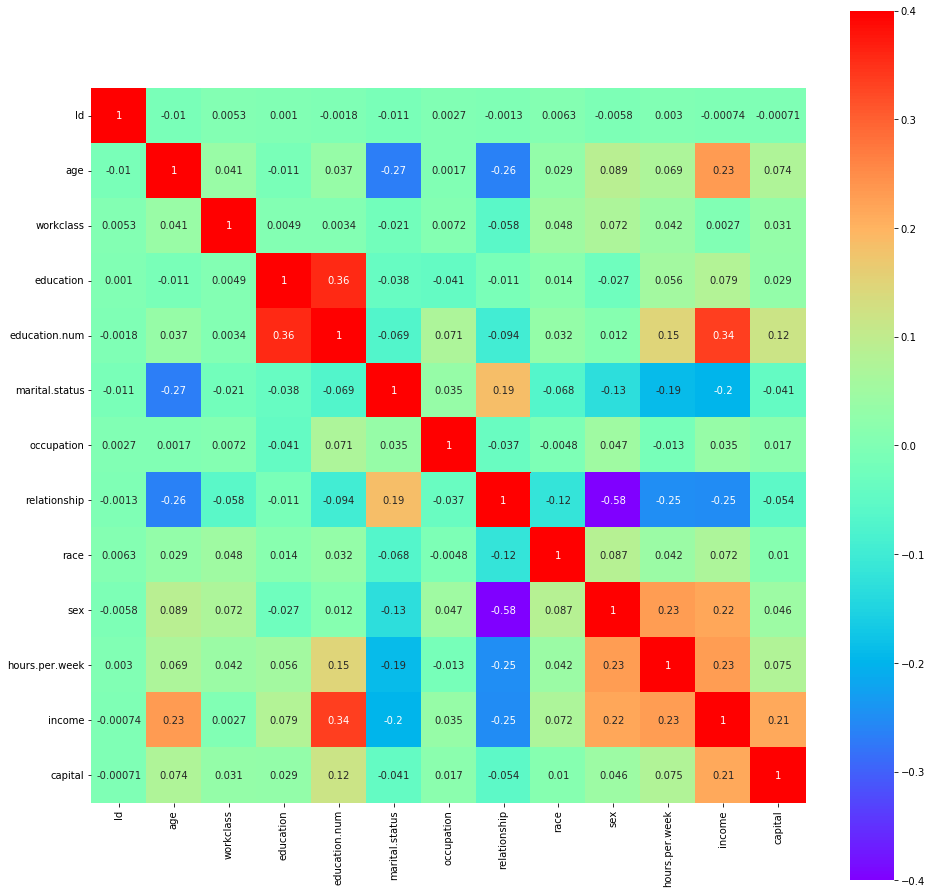

In [16]:
plt.figure(figsize=(16,16))
sns.heatmap(train.corr(), cmap='rainbow',vmin = -0.4, vmax = 0.4, annot=True, square=True)
plt.show()

Pela heatmap acima podemos ver que os parâmetros com maiores covariâncias são: hours per week, capital, education num e age; assim, fazendo a normalização dos valores deles teremos uma precisão maior visto o quão influentes positivamente para o modelo eles são. Também vemos que o Id e race têm covariância muito próxima de zero e education tem covariância muito menor em comparaçao com education num, portanto podemos retirá-los dos parâmetros do modelo.


In [17]:
alto_cov = ["age", "education.num", "hours.per.week"]
train[alto_cov] = StandardScaler().fit_transform(train[alto_cov])

Em seguida, para treinar o modelo e fazer sua validação, foi separada a base de dados em 80% para treino e 20% para validação.

In [18]:
#separação dos dados
training = train.iloc[:6512, :]
validation = train.iloc[6513:, :]

Ytrain = training.income
Xtrain = training.drop(columns=["Id", "income",  "relationship", "education", "race"])

Yvalidation = validation.income
Xvalidation = validation.drop(columns=["Id", "income",  "relationship", "education", "race"])
Xtrain.head()


,age,workclass,education.num,marital.status,occupation,sex,hours.per.week,capital
0,-0.335886,3.0,-0.031325,0.0,3.0,1.0,0.288524,0.0
1,1.423589,1.0,-1.586131,2.0,13.0,1.0,-0.035430,0.0
2,-0.995689,3.0,-0.031325,4.0,6.0,1.0,0.126547,0.0
3,-1.069001,3.0,-0.031325,0.0,0.0,0.0,-0.035430,0.0
4,1.350277,4.0,-0.420027,2.0,13.0,1.0,1.584340,5178.0


## 2. Criação do Modelo KNN

Por meio de testes foi possível observar que o k que nos dá melhor resultado é 21 e cv = 10


In [19]:
modelo = KNeighborsClassifier(n_neighbors = 21)

score = cross_val_score(modelo, Xtrain, Ytrain, cv = 10)
modelo.fit(Xtrain, Ytrain)

KNeighborsClassifier(n_neighbors=21)

In [20]:
YPred = modelo.predict(Xvalidation)

In [21]:
accuracy_score(Yvalidation, YPred)

0.8536107805121511

## 3. Submissão das predicitions para a base de teste

O primeiro passo é organizar a base de teste seguindo os padrões utilizados para a base de treino

In [23]:
test = pd.read_csv("~/Downloads//adult-pmr3508/test_data.csv", 
                     sep = r'\s*,\s*', engine  = 'python',  na_values = "?")

Xtest = test.copy()

test["capital"] = test['capital.gain'] - test['capital.loss']

#variaveis descartadas para a avaliacao de acordo com os graficos
test.drop('capital.loss', axis = 'columns', inplace = True)
test.drop('capital.gain', axis = 'columns', inplace = True)
test.drop('fnlwgt', axis = 'columns', inplace = True)
test.drop('native.country', axis = 'columns', inplace = True)
test.drop('Id', axis = 'columns', inplace = True)
test.drop('relationship', axis = 'columns', inplace = True)
test.drop('education', axis = 'columns', inplace = True)
test.drop('race', axis = 'columns', inplace = True)


#substitui os valores
test["workclass"] = test["workclass"].fillna('Private')
test["occupation"] = test["occupation"].fillna('Prof-specialty')

test

,age,workclass,education.num,marital.status,occupation,sex,hours.per.week,capital
0,25,Private,13,Never-married,Prof-specialty,Male,44,0
1,64,State-gov,13,Married-civ-spouse,Exec-managerial,Male,45,0
2,31,Private,14,Divorced,Exec-managerial,Female,40,0
3,45,Private,9,Never-married,Machine-op-inspct,Male,40,0
4,64,Self-emp-inc,13,Married-civ-spouse,Exec-managerial,Male,50,0
...,...,...,...,...,...,...,...,...
16275,40,Private,9,Married-civ-spouse,Craft-repair,Male,40,0
16276,30,Local-gov,9,Married-civ-spouse,Other-service,Male,40,0
16277,25,Private,9,Never-married,Adm-clerical,Male,40,0
16278,60,Private,14,Never-married,Exec-managerial,Female,35,3325


In [24]:
# convertendo variáveis qualitativas para um valor numérico
qualitativos = [ "workclass", "marital.status", "occupation", "sex"]

test[qualitativos] = OrdinalEncoder().fit_transform(test[qualitativos])
test.head()

,age,workclass,education.num,marital.status,occupation,sex,hours.per.week,capital
0,25,3.0,13,4.0,9.0,1.0,44,0
1,64,6.0,13,2.0,3.0,1.0,45,0
2,31,3.0,14,0.0,3.0,0.0,40,0
3,45,3.0,9,4.0,6.0,1.0,40,0
4,64,4.0,13,2.0,3.0,1.0,50,0


In [25]:
#normalizando os vetores
cap = ["capital"]
test[cap] = RobustScaler().fit_transform(test[cap])

alto_cov = ["age", "education.num", "hours.per.week"]
test[alto_cov] = StandardScaler().fit_transform(test[alto_cov])

Terminada a organização, é feita a previsão e obtido o resultado final

In [26]:
predictions = modelo.predict(test)

#inversão dos valores devolta para strings
predictions = la_encoder.inverse_transform(predictions)

predictions

array(['<=50K', '>50K', '<=50K', ..., '<=50K', '<=50K', '>50K'],
      dtype=object)

In [27]:
submit = pd.DataFrame({'Id': Xtest.Id, 'income': predictions})
submit.to_csv('submission.csv', index = False, )
submit

,Id,income
0,0,<=50K
1,1,>50K
2,2,<=50K
3,3,<=50K
4,4,>50K
...,...,...
16275,16275,<=50K
16276,16276,<=50K
16277,16277,<=50K
16278,16278,<=50K
